In [37]:
%load_ext autoreload
%autoreload 2

from xml.etree.ElementTree import Element, SubElement, ElementTree
from nxedit.xml_generator.utils import save_root_as_xml
from nxedit.xml_generator.xml_maker import prepare_header
import networkx as nx

import joblib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


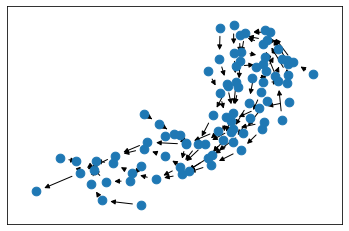

In [38]:
g=joblib.load("temp/g.bin")

pos = nx.spring_layout(g)
pos
nx.draw_networkx(g, pos, with_labels=False, node_shape='.')

In [39]:
#header
root=prepare_header()

#main nodes
process= Element("bpmn:process")

#content
root.append(process)
process.set("id","Process_1")
process.set("isExecutable","false")

for node_id in g.nodes:
    content=g.nodes[node_id]["node_name"]

    task= Element("bpmn:task")
    process.append(task)
    task.set("id",node_id)
    task.set("name",content)



#view
diagram=Element("bpmndi:BPMNDiagram")
root.append(diagram)
diagram.set("id","BPMNDiagram_1")
plane=Element("bpmndi:BPMNPlane")
diagram.append(plane)
plane.set("id","BPMNPlane_1")
plane.set("bpmnElement","Process_1")


for node_id in g.nodes:
    content=g.nodes[node_id]["node_name"]
    shape= Element("bpmndi:BPMNShape")
    plane.append(shape)
    shape.set("id",node_id+"_di")
    shape.set("bpmnElement",node_id)

    bounds=Element("dc:Bounds")
    shape.append(bounds)
    bounds.set("height","80")
    bounds.set("width","100")
    bounds.set("x",str(int(pos[node_id][0]*10**3)))
    bounds.set("y",str(int(pos[node_id][1]*10**3)))


save_root_as_xml(root,"temp/example.xml")
